In [1]:
import tensorflow as tf 
import os
import cv2 as cv 
import keras
import numpy as np 
import math
from matplotlib import pyplot as plt 
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
Image_size =256
Batch_size =32
Channels =3
Epoch = 20

In [3]:
datasets = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset',
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size,
    label_mode='binary'  # Ensure binary labels (0.0 or 1.0) for binary classification
)

Found 1322 files belonging to 2 classes.


In [4]:
classname = datasets.class_names
classname

['Bad cube', 'Good cube']

In [5]:
len(datasets)

42

In [6]:
initial_split = 0.9  # 90% for training to later split into train and test
validation_split = 0.1  # 10% for validation

# The directory where your dataset is located
dataset_dir = 'Dataset'

# Create the training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size,
    shuffle=True
)
# Calculate the number of batches in the training dataset
total_train_batches = len(train_ds)

# Calculate the number of batches for 10% of the data
test_size = int(total_train_batches * 0.1)

# Split the training dataset into training and testing
test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)
input_shape = (Image_size, Image_size, 3)
n_classes = 1

Found 1322 files belonging to 2 classes.
Using 1190 files for training.
Found 1322 files belonging to 2 classes.
Using 132 files for validation.


In [38]:
#pre-trained MobileNetV2 model, excluding its top (classification) layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(Image_size, Image_size, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model to prevent weights from being updated during training
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Adjusted for binary classification
              metrics=['accuracy'])


# Model summary to see all layers
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_26 (Dense)            (None, 64)                81984     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 82049 (320.50 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [39]:
# Training the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Adjust the number of epochs based on your dataset size and desired training time
)

# Optional: Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print('\nTest accuracy:', test_acc)


Epoch 1/10
180/180 [==============================] - 25s 108ms/step - loss: 0.6611 - accuracy: 0.6162 - val_loss: 0.5808 - val_accuracy: 0.6818
Epoch 2/10
180/180 [==============================] - 19s 104ms/step - loss: 0.5857 - accuracy: 0.6924 - val_loss: 0.5548 - val_accuracy: 0.6818
Epoch 3/10
180/180 [==============================] - 19s 103ms/step - loss: 0.5450 - accuracy: 0.7147 - val_loss: 0.5210 - val_accuracy: 0.7273
Epoch 4/10
180/180 [==============================] - 19s 105ms/step - loss: 0.5380 - accuracy: 0.7286 - val_loss: 0.5394 - val_accuracy: 0.7197
Epoch 5/10
180/180 [==============================] - 18s 100ms/step - loss: 0.5032 - accuracy: 0.7602 - val_loss: 0.4839 - val_accuracy: 0.7576
Epoch 6/10
180/180 [==============================] - 18s 101ms/step - loss: 0.4825 - accuracy: 0.7630 - val_loss: 0.5169 - val_accuracy: 0.7273
Epoch 7/10
180/180 [==============================] - 19s 102ms/step - loss: 0.4663 - accuracy: 0.7881 - val_loss: 0.5352 - val_ac

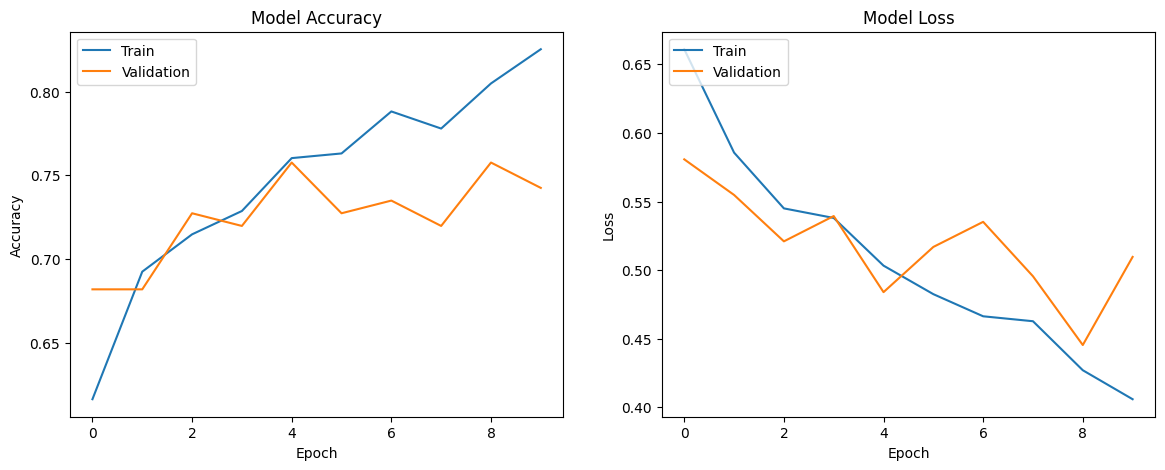

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
base_model = tf.keras.applications.MobileNetV2(input_shape=(Image_size, Image_size, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
   # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(n_classes, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # More epochs since we're using early stopping
    callbacks=[early_stopping_cb, reduce_lr_cb]
)


Epoch 1/25
180/180 [==============================] - 24s 97ms/step - loss: 0.6912 - accuracy: 0.5864 - val_loss: 0.6266 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 2/25
180/180 [==============================] - 16s 90ms/step - loss: 0.6491 - accuracy: 0.6171 - val_loss: 0.6303 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 3/25
180/180 [==============================] - 16s 88ms/step - loss: 0.6200 - accuracy: 0.6654 - val_loss: 0.5797 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 4/25
180/180 [==============================] - 17s 92ms/step - loss: 0.6050 - accuracy: 0.6599 - val_loss: 0.5863 - val_accuracy: 0.6439 - lr: 0.0010
Epoch 5/25
180/180 [==============================] - 18s 98ms/step - loss: 0.5904 - accuracy: 0.6757 - val_loss: 0.5598 - val_accuracy: 0.7121 - lr: 0.0010
Epoch 6/25
180/180 [==============================] - 18s 100ms/step - loss: 0.5855 - accuracy: 0.6766 - val_loss: 0.5464 - val_accuracy: 0.6970 - lr: 0.0010
Epoch 7/25
180/180 [==============================] - 18s

In [44]:
test_loss, test_acc = model.evaluate(test_ds)
print('\nTest accuracy:', test_acc)

19/19 [==============================] - 2s 93ms/step - loss: 0.3982 - accuracy: 0.8596

Test accuracy: 0.859649121761322


In [45]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_28 (Dense)            (None, 64)                81984     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 820

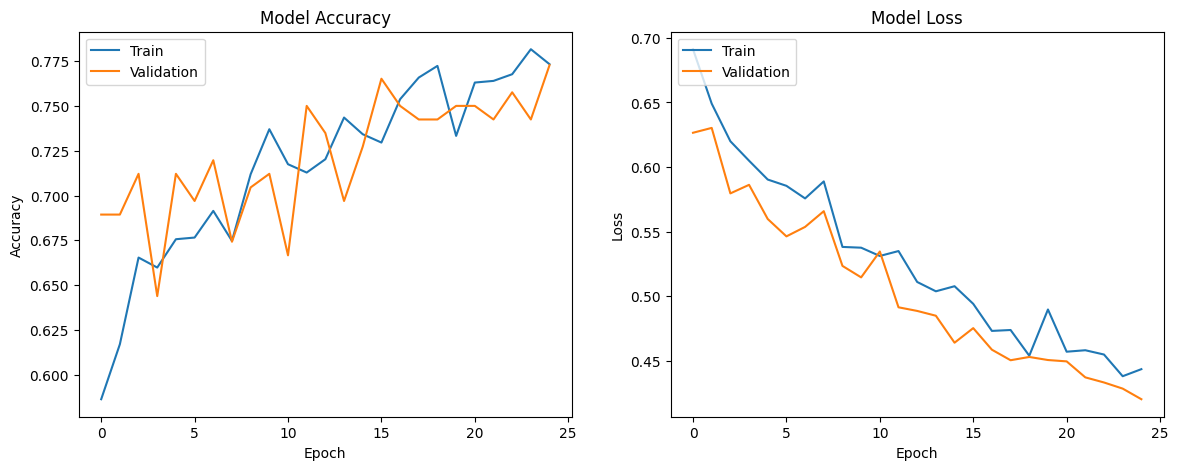

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()
